In [1]:
import langgraph

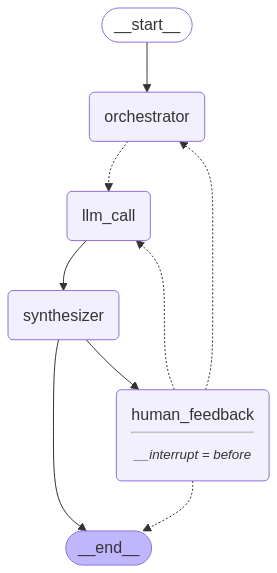

In [ ]:
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.constants import Send
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing import Annotated, List
import operator
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str
    feedback:str # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]
    feedback: str

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic'] +state['feedback']}"),
        ]
    )

    #print("Report Sections:",report_sections)
    names = [section.name for section in report_sections.sections]
    print(f'Section : {names}')
    print(f"what goes thorught orchestator :{report_sections.sections}")
    return {"sections": report_sections.sections}



def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    feedback = state.get('feedback', '')
    try:
        feedback=feedback.split(',')[1]
    except:
        pass
    print(f'human feedback : {feedback}')
    # print(f"state recibido en llm :{state}")
    # Generate section
    
    section = llm.invoke(
        [
            SystemMessage(
                content=f"Write a report section following the provided name and description Focus on {feedback}. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    print(f'report:{completed_report_sections}')
    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker LLM to each section in parallel"""
    
    
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def human_feedback(state: State):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: State):
    """ Return the next node to execute """
    # Check if human feedback
    print(f"state anterior: {state}")
    human_feedback=state.get('feedback', None)
    print(human_feedback)
    if human_feedback == 'like':
        return END
    elif 'structure' in human_feedback:
        if "sections" not in state or not state["sections"]:
            previous_state = memory.load_state(state.get("thread_id", "1"))
            state["sections"] = previous_state.get("sections", [])
            print(f" state feedback:  {state['feedback']}" )
        return [Send("llm_call", {"section": s, "feedback": human_feedback}) for s in state["sections"]]

    else:
        print(f' state tra escribir feedback:{state}')# Otherwise end
        return 'orchestrator' # Regresa al orquestador

orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)
orchestrator_worker_builder.add_node("human_feedback", human_feedback)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)


orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", "human_feedback")

orchestrator_worker_builder.add_edge("synthesizer", END)
orchestrator_worker_builder.add_conditional_edges(
    "human_feedback", should_continue, ["orchestrator",'llm_call',END])


memory=MemorySaver()
# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Show the workflow
try:
    display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))
except:
    pass

# Invoke
# state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
#Markdown(state["final_report"])

In [ ]:
# thread={"configurable":{"thread_id":"1"}}
# initial_input = {
#     "topic": 'genAI',
#     'sections': [],  # List of report sections
#     'completed_sections': [],
#     'final_report': '',
#     'feedback':'',}
    
# state = orchestrator_worker.invoke(input=initial_input,config=thread)

Section : ['Introduction', 'Technological Foundations', 'Applications and Use Cases', 'Challenges and Ethical Considerations', 'Future Prospects']
lo que se pasa :[Section(name='Introduction', description='An overview of genAI, its definition, and significance in the modern technological landscape.'), Section(name='Technological Foundations', description='An exploration of the foundational technologies behind genAI, such as deep learning, neural networks, and natural language processing.'), Section(name='Applications and Use Cases', description='A discussion on the various applications of genAI across different industries including healthcare, finance, and media.'), Section(name='Challenges and Ethical Considerations', description='An analysis of the challenges and ethical issues associated with the development and deployment of genAI technologies.'), Section(name='Future Prospects', description='A forward-looking section that speculates on the future of genAI, its potential impact on 

In [43]:
initial_input = {
    "topic": 'genAI',
    'sections': [],  # List of report sections
    'completed_sections': [],
    'final_report': '',
    'feedback':'',
    
}
thread={"configurable":{"thread_id":"1"}}



In [48]:
initial_input = {
    "topic": 'genAI',
    'sections': [],  # List of report sections
    'completed_sections': [],
    'final_report': '',
    'feedback':'',
    
}
thread={"configurable":{"thread_id":"1"}}


for event in orchestrator_worker.stream(initial_input,thread,stream_mode='values'):
    print(event)


{'topic': 'genAI', 'sections': [], 'completed_sections': [], 'final_report': '', 'feedback': ''}
Section : ['Introduction to genAI', 'Applications of genAI', 'Technical Aspects of genAI', 'Ethical Considerations', 'Future Prospects of genAI']
what goes thorught orchestator :[Section(name='Introduction to genAI', description='An overview of genAI, its definition, and the basic concepts related to it.'), Section(name='Applications of genAI', description='Discussion of various applications of genAI in different industries.'), Section(name='Technical Aspects of genAI', description='Explanation of the technical details behind genAI, including algorithms, models, and technologies used.'), Section(name='Ethical Considerations', description='Analysis of the ethical implications of using genAI, including privacy, bias, and fairness.'), Section(name='Future Prospects of genAI', description='Speculation on the future of genAI, including potential advancements and challenges.')]
{'topic': 'genAI',

ValueError: empty separator

In [376]:
state=orchestrator_worker.get_state(thread)
state

StateSnapshot(values={'topic': 'genAI', 'sections': [Section(name='Introduction to genAI', description='An overview of what genAI is, including its definition, key technologies, and how it differs from traditional AI.'), Section(name='Applications of genAI', description='Discussion on the current use cases of genAI in various industries such as healthcare, finance, and media.'), Section(name='Recent Advancements', description='A look at the latest developments and innovations in the field of genAI.'), Section(name='Challenges and Ethical Considerations', description='An exploration of the challenges associated with genAI, including ethical issues around data privacy and bias.'), Section(name='Future Outlook', description='Predictions and analysis on the future direction and impact of genAI on society and technology.')], 'completed_sections': ['## Introduction to genAI\n\ngenAI, or generative artificial intelligence, refers to a subset of AI technologies focused on creating new content,

In [361]:
state.values['completed_sections']

['GenAI, or Generative Artificial Intelligence, refers to AI systems that generate new digital content such as text, images, and music. These systems are trained on large datasets and use complex algorithms to create outputs that can mimic human-like creativity and insight. The importance of genAI lies in its potential to revolutionize various sectors including content creation, entertainment, education, and even scientific research. By automating and enhancing the creation process, genAI can significantly reduce the time and resources required for developing new content, thereby enabling faster innovation and discovery.\n\nThis report aims to provide a comprehensive overview of genAI, discussing its technological foundations, applications across different industries, and the ethical considerations and challenges associated with its development and deployment. The purpose is to offer readers a clear understanding of the current state and future potential of genAI, along with its implic

In [45]:
state=orchestrator_worker.get_state(thread)

state.next
orchestrator_worker.update_state(thread, {"feedback": 
                            "structure, shorter "}, as_node="human_feedback")

state anterior: {'feedback': 'structure, shorter ', 'topic': 'genAI', 'sections': [Section(name='Introduction to genAI', description="An overview of genAI, its history, and its significance in today's technological landscape."), Section(name='Applications of genAI', description='Discussion on the various applications of genAI in different industries like healthcare, finance, and entertainment.'), Section(name='Technological Foundations', description='Breakdown of the key technologies and methodologies that make genAI possible, such as deep learning, neural networks, and natural language processing.'), Section(name='Challenges and Limitations', description='An exploration of the challenges and limitations associated with genAI, including issues of bias, data privacy, and ethical considerations.'), Section(name='Future of genAI', description='A forward-looking section that discusses the future trends, potential advancements, and the impact of genAI on society.')], 'completed_sections': [

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff8c66-df13-67d3-8004-10e25e5bfbaa'}}

In [369]:
state.next

('human_feedback',)

In [46]:
for event in orchestrator_worker.stream(None, thread, stream_mode='values'):
    print(event)

{'topic': 'genAI', 'sections': [Section(name='Introduction to genAI', description="An overview of genAI, its history, and its significance in today's technological landscape."), Section(name='Applications of genAI', description='Discussion on the various applications of genAI in different industries like healthcare, finance, and entertainment.'), Section(name='Technological Foundations', description='Breakdown of the key technologies and methodologies that make genAI possible, such as deep learning, neural networks, and natural language processing.'), Section(name='Challenges and Limitations', description='An exploration of the challenges and limitations associated with genAI, including issues of bias, data privacy, and ethical considerations.'), Section(name='Future of genAI', description='A forward-looking section that discusses the future trends, potential advancements, and the impact of genAI on society.')], 'completed_sections': ['## Introduction to genAI\n\nGenerative Artificial 

In [41]:
for event in orchestrator_worker.stream(None, thread, stream_mode="values"):
    print(event)

{'topic': 'genAI', 'sections': [Section(name='Introduction to genAI', description='An overview of what general artificial intelligence is, distinguishing it from narrow AI and discussing the goal of creating systems that can understand, learn, and apply knowledge across a wide range of tasks.'), Section(name='Applications of genAI', description='Exploring various fields where genAI could be applied, such as healthcare, education, and autonomous systems.'), Section(name='Technical Foundations', description='Describing the foundational technologies that are key to developing genAI, including machine learning, deep learning, and natural language processing.'), Section(name='Ethical Implications', description='Discussing the ethical considerations and challenges associated with the development and deployment of genAI.'), Section(name='Future Prospects', description='Outlining potential future developments in genAI, including challenges and opportunities.')], 'completed_sections': [], 'fina

In [303]:
memory??

Type:        InMemorySaver
String form: <langgraph.checkpoint.memory.InMemorySaver object at 0x0000019E9E441490>
File:        c:\users\eduardo\documents\prueba_ds\krish\venv\lib\site-packages\langgraph\checkpoint\memory\__init__.py
Source:     
class InMemorySaver(
    BaseCheckpointSaver[str], AbstractContextManager, AbstractAsyncContextManager
):
    """An in-memory checkpoint saver.

    This checkpoint saver stores checkpoints in memory using a defaultdict.

    Note:
        Only use `InMemorySaver` for debugging or testing purposes.
        For production use cases we recommend installing [langgraph-checkpoint-postgres](https://pypi.org/project/langgraph-checkpoint-postgres/) and using `PostgresSaver` / `AsyncPostgresSaver`.

    Args:
        serde (Optional[SerializerProtocol]): The serializer to use for serializing and deserializing checkpoints. Defaults to None.

    Examples:

            import asyncio

            from langgraph.checkpoint.memory import InMemorySaver
     

In [306]:
state??

Type:        StateSnapshot
String form: StateSnapshot(values={'topic': 'genAI', 'sections': [Section(name='Introduction to genAI', description='An overview of what genAI is, its history, and its significance in the field of artificial intelligence.'), Section(name='Applications of genAI', description='Discussion on how genAI is currently being used in various industries such as healthcare, finance, and technology.'), Section(name='Current Research in genAI', description='An exploration of the latest research and developments in the field of genAI.'), Section(name='Ethical Considerations', description='An analysis of the ethical issues related to the use and development of genAI, including privacy, bias, and accountability.'), Section(name='Future Trends', description='A look at the future of genAI, including potential advancements and implications for society.')], 'completed_sections': ["# Introduction to genAI\n\ngenAI, or generative artificial intelligence, refers to AI systems that 